### A Bayesian implementation of a Schaefer Surplus Production population dynamics model

#### **Background**

A Surplus Production Model (SPM) describes the population biomass dynamics as a single biomass entity, conditioned on relative abundance observations. SPMs are based on theta-logistic density-dependent population growth theory, where population growth rates are higher at low abundance, and lower when approaching the carrying capacity.

For a SPM in discrete time, the biomass (B) at a given point in time (usually years) can be described as a function of the biomass, surplus production (P), and catch (C) at the previous year.

$$
B_{t} = B_{t-1} + P_{t-1} - C_{t-1}
$$

The surplus production $P$ (i.e. the population growth in biomass at a given point in time) is a function of two parameters: the intrinsic rate of increase ($r$), and carrying capacity (K):

$$
P_{t} = rB_{t}\left(1 - \frac{B_{t}}{K}\right) - F_{t}B_{t}
$$

Observations are indices of relative abundance ($I$) scaled to biomass through (estimated) cachability coefficients $q$:

$$
\hat{I} = qB_{t}
$$

#### **Model Setup**

- **Data:** Observed catches `C` and one or more survey indices (columns starting with "Survey" followed by a number) over multiple years.

#### **Likelihood**

For each survey index, the likelihood is based on the log-normal errors between observed survey values and predicted biomass. The model assumes:

- The observed survey index at time $t$ is $I_t$.
- The predicted biomass at time $t$ (from the Schaefer model) is $B_t$.
- The catchability coefficient $Q$ scales the expected survey to the biomass:
  $$
  Q = \exp\left(\frac{1}{n} \sum_{t=1}^n \log\left(\frac{I_t}{B_t}\right)\right)
  $$
- The scaled prediction for the survey is $P_t = I_t / Q$.

The residuals follow a log-normal distribution:
  $$
  \log\left(\frac{B_t}{P_t}\right) \sim N(0, \sigma^2)
  $$

This means that for each year $t$, the probability density of observing $I_t$ given predicted $B_t$ and $\sigma$ is:
  $$
  p(I_t \mid B_t, Q, \sigma) = \frac{1}{\sqrt{2\pi}\,\sigma} \exp\left( -\frac{1}{2\sigma^2} \left[\log\left(\frac{B_t}{I_t/Q}\right)\right]^2 \right)
  $$

For each residual:
  $$
  \text{residual}_t = \log\left(\frac{B_t}{I_t/Q}\right)
  $$
and
  $$
  p(\text{residual}_t \mid \sigma) = \frac{1}{\sqrt{2\pi}\,\sigma} \exp\left( -\frac{\text{residual}_t^2}{2\sigma^2} \right)
  $$

The **total likelihood** across years is the product of these normal pdfs across observations.

---

#### **Prior**

- Priors are placed on the parameters:
  - $r \sim N(\mu_r, \sigma^2_r)$
  - $k \sim N(\mu_k, \sigma^2_k)$
  - $\sigma \sim N(\mu_\sigma, \sigma^2_\sigma)$
- These are combined into the total NLL for use in Metropolis-Hastings.

---

#### **Posterior**

- The (unormalized) posterior combines the likelihood and priors:
  $$
  p(r, k, \sigma | \text{data}) \propto p(\text{data} | r, k, \sigma) \cdot p(r) \cdot p(k) \cdot p(\sigma)
  $$

---

#### **Metropolis-Hastings Algorithm Steps in the Code**

1. **Initialization:**
   - Chains are initialized at given starting values (`inits`).

2. **Proposal Step:**
   - At each iteration, propose new values for $r$, $k$, and $\sigma$ using normal random walks:
     $$
     r^* \sim N(r^{(t-1)}, \delta_{1}), \quad k^* \sim N(k^{(t-1)}, \delta_{2}), \quad \sigma^* \sim |N(\sigma^{(t-1)}, \delta_{2})|
     $$
   - Hard rejection if the proposed $r^* \leq 0$.

3. **Acceptance Ratio:**
   - Compute the difference in negative log-likelihoods (including priors) between proposal and current values.
   - Accept the proposal with probability $\min(1, \exp(\text{logR}))$.

4. **Update Step:**
   - If accepted, set $(r, k, \sigma)^{(t)} = (r^*, k^*, \sigma^*)$; otherwise, retain previous values.
   - Repeat for `nIter` iterations, discarding `nBurnIn` as burn-in.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
def detect_survey_cols(data):
    # Find all columns that start with 'Survey'
    return [col for col in data.columns if col.lower().startswith("survey")]

def NLL(par, data, survey_cols, priorMean, priorVar, printStep=False):
    r, k, sigma = float(par[0]), float(par[1]), float(par[2])
    nYears = len(data)
    B = np.zeros(nYears)
    B[0] = k

    for t in range(1, nYears):
        B[t] = max(1, B[t-1] + r * B[t-1] * (1 - B[t-1] / k) - data['C'].iloc[t-1])

    # Likelihood components for each survey
    NLLs = []
    for survey_col in survey_cols:
        survey_vals = data[survey_col]
        Q   = np.exp(np.nanmean(np.log(survey_vals / B)))
        PB  = survey_vals / Q
        SSQ = np.log(B / PB) ** 2
        idx = ~np.isnan(SSQ)
        L = 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-SSQ[idx] / (2 * sigma ** 2))
        NLLs.append(-np.log(L))

    # Priors
    rPriorL     = -((r - priorMean[0]) ** 2 / (2 * priorVar[0]))
    kPriorL     = -((k - priorMean[1]) ** 2 / (2 * priorVar[1]))
    sigmaPriorL = -((sigma - priorMean[2]) ** 2 / (2 * priorVar[2]))
    priorL = rPriorL + kPriorL + sigmaPriorL

    # Total negative log-likelihood (minus sum for M-H log acceptance ratio)
    totalNLL = sum(-np.sum(nll) for nll in NLLs) + priorL

    if printStep:
        print(f"r: {r:.4f} k: {k:.2f} sigma: {sigma:.4f} nll: {totalNLL:.2f}")

    return totalNLL

def schaeferMCMC(data, inits, nIter, nBurnIn, delta, priors, nChains=2):
    """
    Metropolis-Hastings sampler for the Schaefer biomass model.
    Now uses a vector of proposal standard deviations (delta) for each parameter:
        delta[0] = for r
        delta[1] = for k
        delta[2] = for sigma
    """
    survey_cols = detect_survey_cols(data)
    priorMean = priors[:3]
    priorVar  = priors[3:]

    if not (isinstance(delta, (list, tuple, np.ndarray)) and len(delta) == 3):
        raise ValueError("delta must be a list/tuple/array of length 3: [delta_r, delta_k, delta_sigma]")

    chains = []
    for chain_idx in range(nChains):
        r     = np.zeros(nIter)
        k     = np.zeros(nIter)
        sigma = np.zeros(nIter)

        if isinstance(inits[0], (list, np.ndarray)):
            r[0], k[0], sigma[0] = inits[chain_idx]
        else:
            r[0], k[0], sigma[0] = inits

        for i in range(1, nIter):
            rHat     = np.random.normal(r[i-1], delta[0])
            kHat     = np.random.normal(k[i-1], delta[1])
            sigmaHat = abs(np.random.normal(sigma[i-1], delta[2]))

            if rHat <= 0:
                r[i], k[i], sigma[i] = r[i-1], k[i-1], sigma[i-1]
                continue

            logR = NLL([rHat, kHat, sigmaHat], data, survey_cols, priorMean, priorVar) - \
                   NLL([r[i-1], k[i-1], sigma[i-1]], data, survey_cols, priorMean, priorVar)

            accept_prob = min(1, np.exp(logR))
            if np.random.uniform() <= accept_prob:
                r[i], k[i], sigma[i] = rHat, kHat, sigmaHat
            else:
                r[i], k[i], sigma[i] = r[i-1], k[i-1], sigma[i-1]

        # Burn-in removal
        rSamples     = r[nBurnIn:]
        kSamples     = k[nBurnIn:]
        sigmaSamples = sigma[nBurnIn:]

        chains.append(pd.DataFrame({
            'r': rSamples,
            'k': kSamples,
            'sigma': sigmaSamples
        }))

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    colors = ['black', '#FF000088', 'blue', 'green', 'orange', 'purple']
    # Traceplots
    for j, param in enumerate(['r', 'k', 'sigma']):
        for cidx, chain in enumerate(chains):
            axs[0, j].plot(chain[param], color=colors[cidx % len(colors)], alpha=0.7, label=f'Chain {cidx+1}' if j==0 else None)
        axs[0, j].set_title(f'Trace: {param}')
        if j == 0:
            axs[0, j].legend()
    # Density plots
    for j, param in enumerate(['r', 'k', 'sigma']):
        for cidx, chain in enumerate(chains):
            kde = gaussian_kde(chain[param])
            x_vals = np.linspace(chain[param].min(), chain[param].max(), 200)
            axs[1, j].plot(x_vals, kde(x_vals), color=colors[cidx % len(colors)], label=f'Chain {cidx+1}')
        axs[1, j].set_title(f'Density: {param}')
        axs[1, j].legend()
    plt.tight_layout()
    plt.show()

    # Posterior summaries (mean and sd per chain)
    summaries = []
    for chain in chains:
        summaries.append(pd.DataFrame({
            'Mean': [chain['r'].mean(), chain['k'].mean(), chain['sigma'].mean()],
            'SD':   [chain['r'].std(),  chain['k'].std(),  chain['sigma'].std()]
        }, index=['r', 'k', 'sigma']))

    output = {
        'chains': chains,
        'summaries': summaries,
        'survey_cols': survey_cols
    }
    return output

def schaefer_post_plots(data, mcmc_samples, survey_cols):
    nYears = len(data)
    nSamples = len(mcmc_samples)
    biomass_matrix = np.zeros((nSamples, nYears))

    # Calculate biomass time series for each posterior sample
    for s in range(nSamples):
        r = mcmc_samples.iloc[s]['r']
        k = mcmc_samples.iloc[s]['k']
        B = np.zeros(nYears)
        B[0] = k
        for t in range(1, nYears):
            B[t] = max(1, B[t-1] + r * B[t-1] * (1 - B[t-1] / k) - data['C'].iloc[t-1])
        biomass_matrix[s, :] = B

    biomass_mean = biomass_matrix.mean(axis=0)
    biomass_lower = np.percentile(biomass_matrix, 2.5, axis=0)
    biomass_upper = np.percentile(biomass_matrix, 97.5, axis=0)

    # ----- SCALE THE SURVEYS -----
    scaled_surveys = {}
    for survey_col in survey_cols:
        survey_vals = data[survey_col].values
        mask = survey_vals > 0
        # Avoid division by zero or log of zero with masking
        q = np.exp(np.nanmean(np.log(survey_vals[mask] / biomass_mean[mask])))
        scaled_surveys[survey_col] = survey_vals / q

    # ----- Plotting -----
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Biomass time series with CI and scaled surveys
    axs[0].plot(biomass_mean, color='black', label='Mean')
    axs[0].plot(biomass_lower, color='black', linestyle='--', label='Lower CI')
    axs[0].plot(biomass_upper, color='black', linestyle='--', label='Upper CI')
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for idx, (survey_col, scaled) in enumerate(scaled_surveys.items()):
        axs[0].plot(np.arange(nYears), scaled, 'o', label=survey_col, color=colors[idx % len(colors)])
    axs[0].set_ylabel("biomass")
    axs[0].set_xlabel("Index")
    axs[0].legend()

    # 2. B/Bmsy
    k_samples = mcmc_samples['k'].values
    bbmsy_matrix = biomass_matrix / (k_samples[:, None] / 2)
    bbmsy_mean = bbmsy_matrix.mean(axis=0)
    axs[1].plot(bbmsy_mean, color='black')
    axs[1].set_ylabel("biomassSB/(k/2)")
    axs[1].set_xlabel("Index")
    axs[1].set_title("B/Bmsy")

    # 3. F/Fmsy
    catch = data['C'].values
    r_samples = mcmc_samples['r'].values
    f_matrix = catch / biomass_matrix
    fmsy_matrix = r_samples[:, None] / 2
    ffmsy_matrix = f_matrix / fmsy_matrix
    ffmsy_mean = ffmsy_matrix.mean(axis=0)
    axs[2].plot(ffmsy_mean, color='black')
    axs[2].set_ylabel("FM/Fmsy")
    axs[2].set_xlabel("Index")
    axs[2].set_title("F/Fmsy")

    plt.tight_layout()
    plt.show()

    return {
        "biomass_mean": biomass_mean,
        "biomass_lower": biomass_lower,
        "biomass_upper": biomass_upper,
        "scaled_surveys": scaled_surveys
    }

Data loaded: (106, 4)


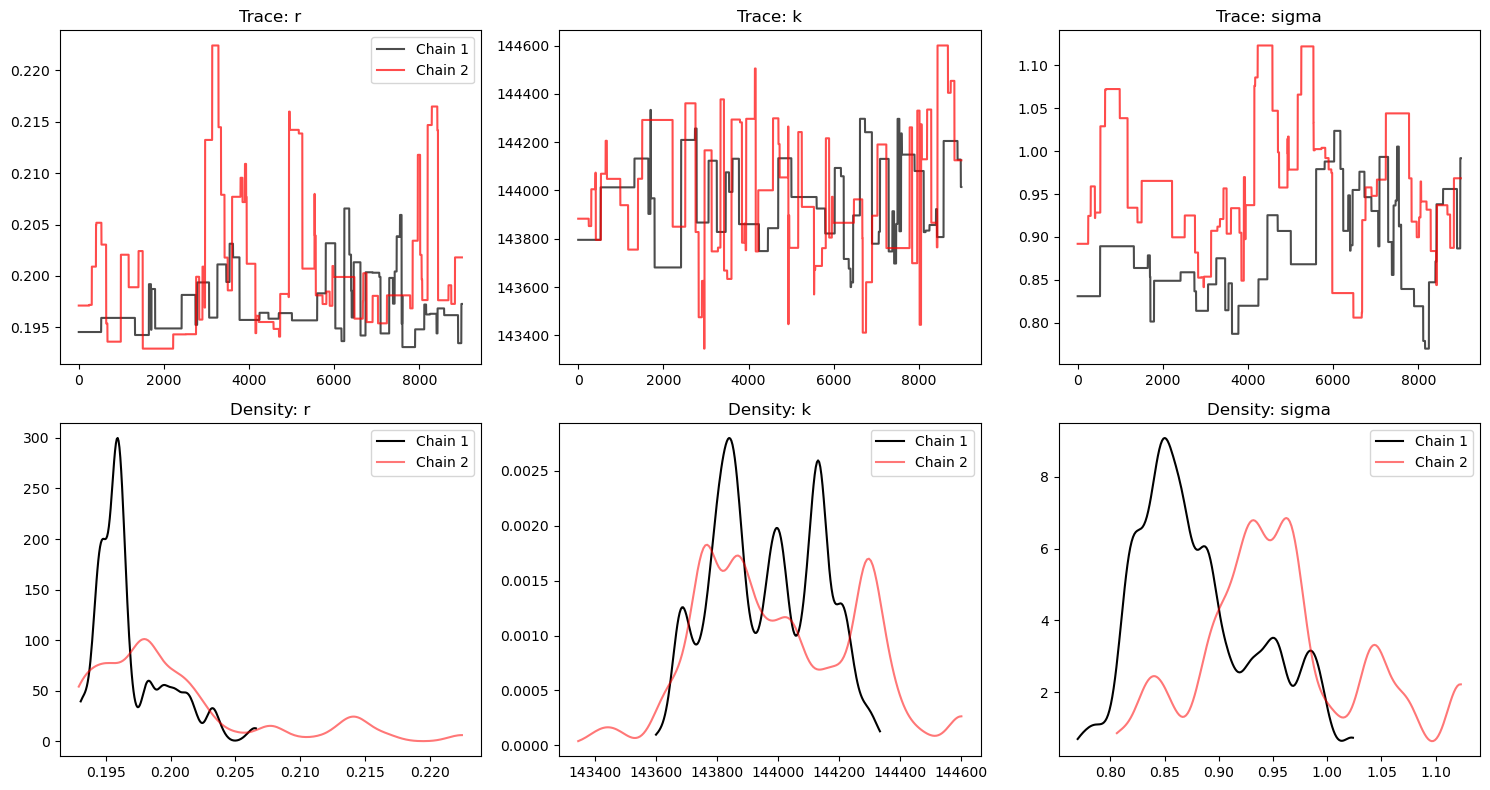

Chain 1 parameter means and SDs:
                Mean          SD
r           0.196915    0.002818
k      143959.081106  171.666639
sigma       0.881992    0.057361

Chain 2 parameter means and SDs:
                Mean          SD
r           0.200125    0.006565
k      144002.313610  256.658980
sigma       0.959083    0.078085



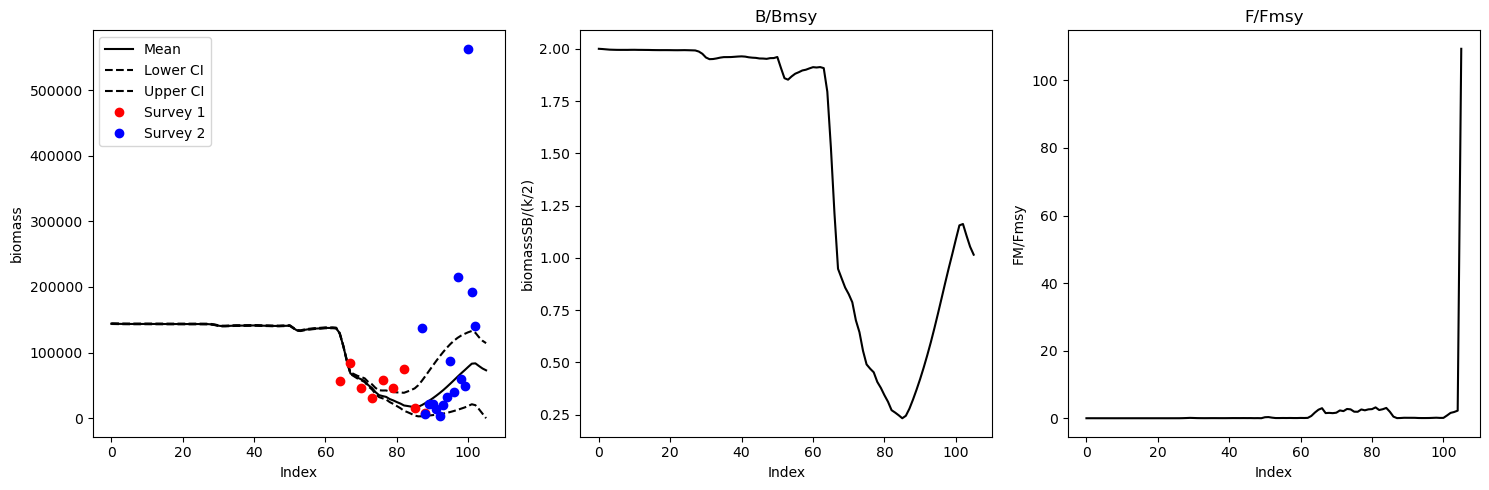

{'biomass_mean': array([144002.31361016, 143924.31361016, 143817.91490768, 143714.7670977 ,
        143675.18689046, 143641.48374972, 143631.48353561, 143634.46532469,
        143629.84578634, 143654.1400488 , 143661.59183402, 143634.5566229 ,
        143628.9033138 , 143614.37286747, 143604.73259465, 143572.00856375,
        143557.79341608, 143546.40250249, 143551.27372563, 143550.17318263,
        143542.28930214, 143522.971406  , 143515.49254973, 143528.49814243,
        143545.91625268, 143515.86996672, 143482.79725002, 143439.29563425,
        143060.43187438, 142286.59254183, 141004.74181753, 140431.98039741,
        140485.52700079, 140693.78968272, 140966.27359047, 141136.57606185,
        141144.16252117, 141162.27436864, 141249.89186523, 141341.64556833,
        141398.72264335, 141308.79509159, 141076.2060726 , 140947.34784568,
        140873.19619457, 140674.23308517, 140647.28900651, 140544.46690566,
        140785.2321482 , 140813.02725336, 141176.50276618, 137443.270579

In [6]:
# --- Example usage ---
data = pd.read_csv('../data/data.csv')
print("Data loaded:", data.shape) # rows, cols

# Initial parameters, number of iterations, burn-in, delta, priors
inits = [0.19, 144000, 0.9] # r, k, sigma
nIter = 200000 # reduce for testing
nBurnIn = 2000
delta = [0.0075, 20000, 0.05] # proposal distribution variances
priors = [0.23, 144000, 0.9, 0.005, 50000, 0.01]  # priors: means (1:3) and variances (4:6)

result = schaeferMCMC(data, inits, nIter, nBurnIn, delta, priors)

# Print means and SDs for each chain
for i, summary in enumerate(result['summaries']):
    print(f"Chain {i+1} parameter means and SDs:\n{summary}\n")

schaefer_post_plots(data, result['chains'][1], result['survey_cols'])